In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError


Loading sequences: 100%|██████████| 10/10 [00:01<00:00,  6.99it/s]


Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - loss: 26694.8965 - mean_absolute_error: 130.8992 - val_loss: 73016.6953 - val_mean_absolute_error: 225.6086
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - loss: 8210.0850 - mean_absolute_error: 74.7094 - val_loss: 54950.0039 - val_mean_absolute_error: 204.0665
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - loss: 4438.5801 - mean_absolute_error: 50.7848 - val_loss: 54405.0586 - val_mean_absolute_error: 205.1915
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - loss: 3115.2058 - mean_absolute_error: 40.4048 - val_loss: 48186.1484 - val_mean_absolute_error: 192.4482
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - loss: 2537.6221 - mean_absolute_error: 37.2413 - val_loss: 46903.3086 - val_mean_absolute_error: 190.2267
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - loss: 2068.3401 - mean_absolute_error: 32.9501 - val_loss: 47786.1094 - val_mean_absolute_error: 189.2072
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step 

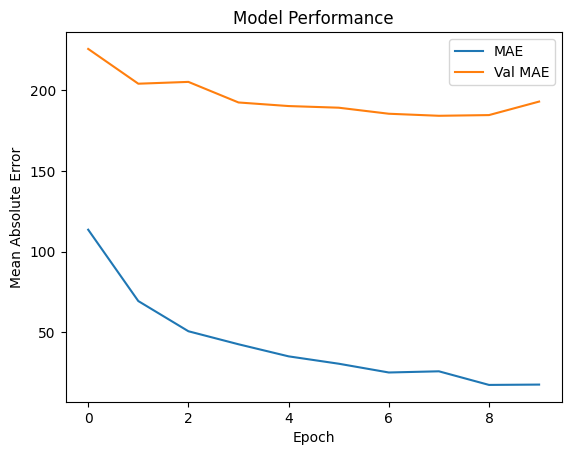

35/35 ━━━━━━━━━━━━━━━━━━━━ 11s 315ms/step - loss: 43792.1250 - mean_absolute_error: 183.4502
Test Loss: 49445.1171875
Test MAE: 193.00399780273438


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bars

# Helper function to parse the tripod sequence file
def parse_tripod_seq_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.read().splitlines()
        image_dims = list(map(int, lines[0].split()))
        num_frames = list(map(int, lines[1].split()))
        frames_360 = list(map(int, lines[4].split()))
        frontal_frames = list(map(int, lines[5].split()))
        rotation_sense = list(map(int, lines[6].split()))
    return image_dims, num_frames, frames_360, frontal_frames, rotation_sense

# Function to load and preprocess image and bbox data
def load_and_preprocess_data(base_path, sequence_ids, img_width, img_height, frames_per_seq, frames_360, frontal_frames, rotation_sense):
    data = []
    labels = []
    bboxes = []

    for i, seq_id in enumerate(tqdm(sequence_ids, desc='Loading sequences')):
        num_frames = frames_per_seq[i]
        num_frames_360 = frames_360[i]
        frontal_frame = frontal_frames[i]
        sense = rotation_sense[i]
        bbox_path = f"{base_path}/bbox_{seq_id:02d}.txt"
        bbox_data = np.loadtxt(bbox_path, delimiter=' ')

        for frame_id in tqdm(range(1, num_frames + 1), desc=f'Processing seq {seq_id}', leave=False):
            filename = f"{base_path}/tripod_seq_{seq_id:02d}_{frame_id:03d}.jpg"
            img = tf.keras.preprocessing.image.load_img(filename, target_size=(img_height, img_width))
            img = tf.keras.preprocessing.image.img_to_array(img)
            img /= 255.0  # Normalize to [0, 1]

            relative_position = (frame_id - frontal_frame) % num_frames_360
            rotation_angle = relative_position * (360 / num_frames_360) * sense

            data.append(img)
            labels.append(rotation_angle)
            bboxes.append(bbox_data[frame_id - 1])  # Add bbox data

    return np.array(data), np.array(labels), np.array(bboxes)

# Building the model
def build_model(input_shape):
    image_input = Input(shape=input_shape, name='image_input')
    bbox_input = Input(shape=(4,), name='bbox_input')

    # CNN layers
    x = Conv2D(32, (3, 3), activation='relu')(image_input)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(2, 2)(x)
    x = Flatten()(x)

    # Concatenate bbox information
    x = concatenate([x, bbox_input])
    x = Dense(512, activation='relu')(x)
    rotation_angle_output = Dense(1)(x)  # Linear output for rotation angle

    model = Model(inputs=[image_input, bbox_input], outputs=rotation_angle_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# Example execution block
if __name__ == "__main__":
    file_path = r'epfl-gims08\tripod-seq\tripod-seq.txt' 
    base_path = r'epfl-gims08\tripod-seq'
    train_sequence_ids = list(range(1, 11))  # Sequences 1-10 for training
    test_sequence_ids = list(range(11, 21))  # Sequences 11-20 for testing

    image_dims, num_frames, frames_360, frontal_frames, rotation_sense = parse_tripod_seq_file(file_path)
    img_width, img_height = image_dims[1], image_dims[2]

    # Load data
    train_images, train_labels, train_bboxes = load_and_preprocess_data(
        base_path, train_sequence_ids, img_width, img_height, num_frames[:10], frames_360[:10], frontal_frames[:10], rotation_sense[:10])
    test_images, test_labels, test_bboxes = load_and_preprocess_data(
        base_path, test_sequence_ids, img_width, img_height, num_frames[10:], frames_360[10:], frontal_frames[10:], rotation_sense[10:])

    # Build and train the model
    model = build_model((img_height, img_width, 3))
    history = model.fit([train_images, train_bboxes], train_labels, epochs=10, validation_data=([test_images, test_bboxes], test_labels))

    # Plot training history
    plt.plot(history.history['mean_absolute_error'], label='MAE')
    plt.plot(history.history['val_mean_absolute_error'], label='Val MAE')
    plt.title('Model Performance')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

    # Evaluate the model
    test_loss, test_mae = model.evaluate([test_images, test_bboxes], test_labels)
    print("Test Loss:", test_loss)
    print("Test MAE:", test_mae)
